In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
#The data relevant to our research question is in the following two files. Note these contain background information about patients (age, sex, etc), as well as information obtained at the paitent's arrival at the ED. 
# Although there is other data available, it is obtained later in the patient's ED stay.
ed_edstays_df = pd.read_csv('../ed_data/edstays.csv.gz', compression='gzip')
ed_triage_df = pd.read_csv('../ed_data/triage.csv.gz', compression='gzip') 
hosp_patients_df = pd.read_csv('../hosp_data/patients.csv.gz', compression='gzip')  

In [3]:
ed_edstays_df['stay_id'].nunique()

425087

In [4]:
# Merge two dataframes edstays and triage
from MergeCleanClasses import DataMerge 
df_merge = DataMerge(ed_edstays_df, ed_triage_df, hosp_patients_df).get_dataframe()

In [5]:
df_merge.columns

Index(['subject_id', 'hadm_id', 'stay_id', 'intime', 'outtime', 'gender',
       'race', 'arrival_transport', 'disposition', 'admission_age',
       'temperature', 'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp', 'pain',
       'acuity', 'chiefcomplaint'],
      dtype='object')

In [ ]:
# Clean the dataframe by replacing abnormal values with np.nan in multiple columns, including
#   stay_length_hours, temperature, resprate, sbp, dbp, o2sat, pain
# Special treatments for several columns:
# 1. For temperature, scale temperature values by 10 (if between 8.24 and 10.10) and by 0.10 (if between 824 and 1010),
#      and convert temperature from Celsius to Fahrenheit (if betweeen 28 and 43.3)
# 2. Exclude data where disposition is 'eloped', 'left without being seen' or 'left against medical advice'
# 3. For pain, 
#   if it's a range (number-number), replace this range by the average (e.g., 6-9 is replaced by 7.5);
#   if it's a number followed by a symbol, strip off the extra symbols and just keep the number  (e.g., '9+' is replaced by 9);
#   it's a single number, convert to a float (covers integer and decimal). Round down to 10 if the result is larger than 10.
# 4. Condense race into fewer categories: 'White', 'OTHER', 'HISPANIC/LATINO', 'ASIAN', 'BLACK', nan,
#    'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER', 'AMERICAN INDIAN/ALASKA NATIVE'
# All above are copied from Emilie's Cleaning.ipynb

# Additional cleaning I made:
# 1. Change stay_length_hours to stay_length_minutes and drop those stay_length_minutes < 1 or > 10000
# 2. Set 'heartrate' to NaN if greater than 400
# 3. Set 'resprate' to NaN if greater than 100 or less than 20
# 4. Scale sbp values up by 10 (if between 5 and 30) and down by 0.10 (if between 500 and 3000)
#    and set 'sbp' to NaN if greater than 300 or less than 50
# 5. Scale dbp values up by 10 (if between 2 and 20) and down by 0.10 (if between 200 and 2000)
#    and set 'dbp' to NaN if greater than 200 or less than 20
# 6. Set O2sat to NaN if greater than 100 or less than 20 
# 7. For chief complaint, drop those rows where chief complaints do not contain any letters. Those are considered as null values such as ['___', '.', '-', nan, '___ ___', '\\', '\x81\x80\x87', '\x88\x87', '1', '0', '\x87', '?', '353', '2', '21', '___ /___', '___, ___', '150', '? ___', '\x89', '___,___', '--']

from MergeCleanClasses import DataCleaner
cleaner=DataCleaner(df_merge)
cleaner.clean_data()
df_cleaned = cleaner.get_dataframe()


In [7]:
df_cleaned.describe()

,subject_id,hadm_id,stay_id,admission_age,temperature,heartrate,resprate,o2sat,sbp,dbp,acuity,stay_length_minutes,pain_cleaned_advanced
count,4.099730e+05,2.009690e+05,4.099730e+05,409901.000000,386970.000000,393218.000000,59869.000000,389703.000000,392068.000000,391218.000000,403114.000000,409973.000000,383558.000000
mean,1.500700e+07,2.499450e+07,3.499759e+07,53.077289,98.087712,85.050677,21.391438,98.389827,135.029382,77.397434,2.617880,435.226365,4.332826
std,2.880169e+06,2.888970e+06,2.887985e+06,20.612036,0.978956,17.723182,3.194889,2.075818,22.388631,14.775016,0.709048,393.844532,3.817120
min,1.000003e+07,2.000002e+07,3.000001e+07,18.000000,82.400000,1.000000,20.000000,42.000000,50.000000,20.000000,1.000000,1.000000,0.000000
25%,1.251441e+07,2.248891e+07,3.249910e+07,35.000000,97.600000,72.000000,20.000000,97.000000,120.000000,68.000000,2.000000,217.000000,0.000000
50%,1.501340e+07,2.499833e+07,3.499260e+07,54.000000,98.000000,84.000000,20.000000,99.000000,133.000000,77.000000,3.000000,332.300000,5.000000
75%,1.750095e+07,2.749324e+07,3.750435e+07,69.000000,98.600000,96.000000,22.000000,100.000000,148.000000,87.000000,3.000000,504.000000,8.000000
max,1.999999e+07,2.999981e+07,3.999996e+07,91.000000,110.000000,256.000000,100.000000,100.000000,299.000000,199.000000,5.000000,9677.000000,10.000000


In [8]:
df_cleaned.columns

Index(['subject_id', 'hadm_id', 'stay_id', 'intime', 'outtime', 'gender',
       'race', 'arrival_transport', 'admission_age', 'temperature',
       'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp', 'pain', 'acuity',
       'chiefcomplaint', 'stay_length_minutes', 'pain_cleaned_advanced',
       'race_condensed'],
      dtype='object')

In [9]:
print(len(df_cleaned['subject_id'].unique()))
print(len(df_cleaned['stay_id'].unique()))

201033
409973


In [10]:
from sklearn.model_selection import train_test_split
train, test= train_test_split(df_cleaned, shuffle = True, random_state = 489,test_size=.1)
train.to_csv('train.csv', index=False)
test.to_csv('test.csv', index=False)

# What about null values? There are 76 data with null admission_age.

In [17]:
print('Number of rows in cleaned training set is', train['stay_id'].nunique())
print('Number of rows in cleaned test set is', test['stay_id'].nunique())

Number of rows in cleaned training set is 368975
Number of rows in cleaned test set is 40998


In [ ]:
# train.head()
# test['stay_id'].nunique()
# train[train['chiefcomplaint'].str != ""]
# train.sample(5)
# train_filtered = train[~train['chiefcomplaint'].str.contains('[a-zA-Z]', na=False)]
# # train_filtered['chiefcomplaint'].unique()
# train_filtered

,subject_id,hadm_id,stay_id,intime,outtime,gender,race,arrival_transport,admission_age,temperature,...,resprate,o2sat,sbp,dbp,pain,acuity,chiefcomplaint,stay_length_minutes,pain_cleaned_advanced,race_condensed


In [ ]:
# df_cleaned[df_cleaned['stay_length_minutes'] <= 5].count()

subject_id               228
hadm_id                   13
stay_id                  228
intime                   228
outtime                  228
gender                   228
race                     228
arrival_transport        228
admission_age            228
temperature               39
heartrate                 44
resprate                   4
o2sat                     44
sbp                       43
dbp                       43
pain                      60
acuity                    67
chiefcomplaint           228
stay_length_minutes      228
pain_cleaned_advanced     46
race_condensed           119
dtype: int64

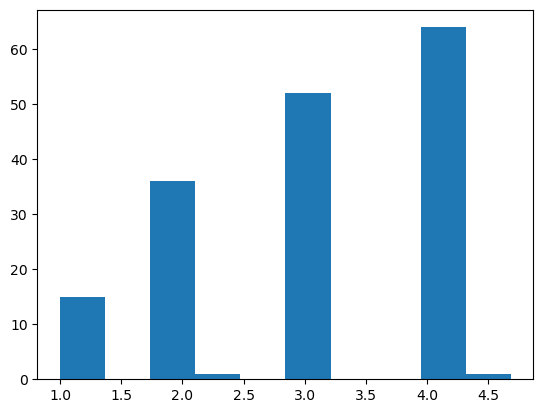

In [ ]:
# plt.hist(df_cleaned[df_cleaned['stay_length_minutes'] < 5]['stay_length_minutes'])
# plt.show()